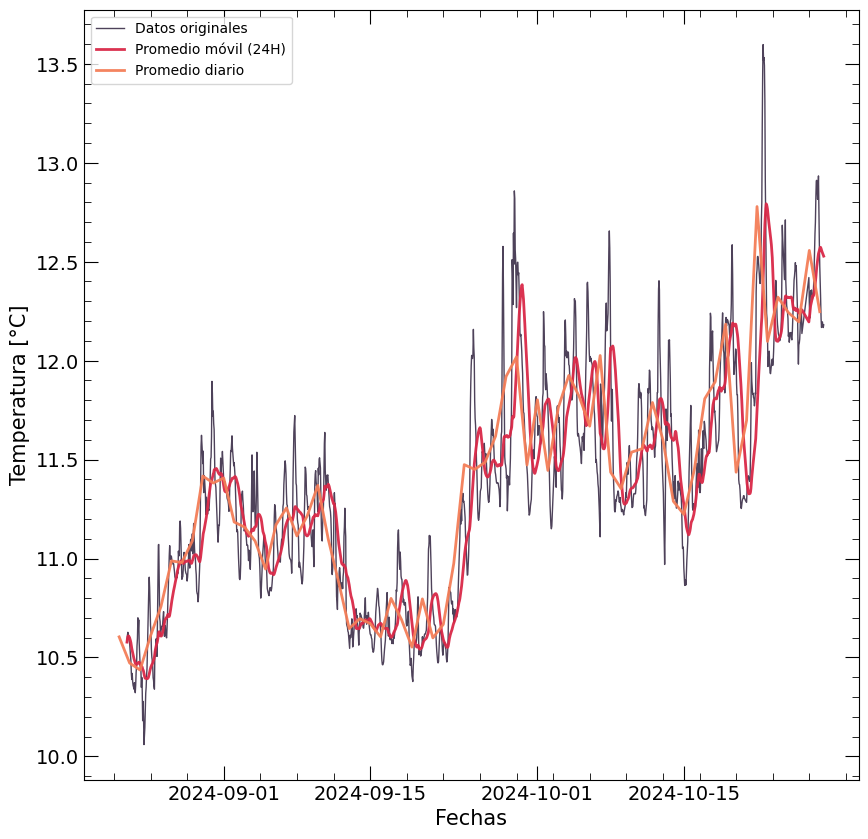

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import seaborn as sns

colors=sns.color_palette("rocket",10)

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

path = os.getcwd()
path_files = os.path.join(path, "time_series_data", "seafettab-temp")

### Obtener paths de todos los archivos .dat
dat_files = glob.glob(os.path.join(path_files, "*.dat"))

dfs = []

### Abrir todos los archivos, darles formato de fechas y concatenarlos en un solo dataframe.

for filename in dat_files:
    df = pd.read_csv(filename, parse_dates=True, index_col=1)
    df.index = pd.to_datetime(df.index, format="%d-%m-%Y %H:%M:%S")
    dfs.append(df)

df_concat = pd.concat(dfs)

df_concat = df_concat.sort_index()

### Media Móvil de 24 horas
df_rolling = df_concat["Dato"].rolling("24H").mean()

### Promedio diario
df_mean = df_concat["Dato"].resample("D").mean() 


axs.plot(df_concat.index, df_concat["Dato"], label='Datos originales', color=colors[0], alpha=0.8, linewidth=1)
axs.plot(df_rolling.index, df_rolling.values, label='Promedio móvil (24H)', color=colors[5], alpha=0.95, linewidth=2)
axs.plot(df_mean.index, df_mean.values, label='Promedio diario', color=colors[7], alpha=0.95, linewidth=2)

### Configuraciones adicionales de los ticks
axs.minorticks_on()
            
axs.tick_params(direction='in', right=True, top=True)
axs.yaxis.set_tick_params(labelsize=14)
axs.xaxis.set_tick_params(labelsize=14)

axs.tick_params(direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
axs.tick_params(direction='in', which='major', length=10, bottom=True, top=True, left=True, right=True)

axs.set_ylabel("Temperatura [°C]", fontsize=15)
axs.set_xlabel("Fechas", fontsize=15)

axs.legend()
plt.show()


        

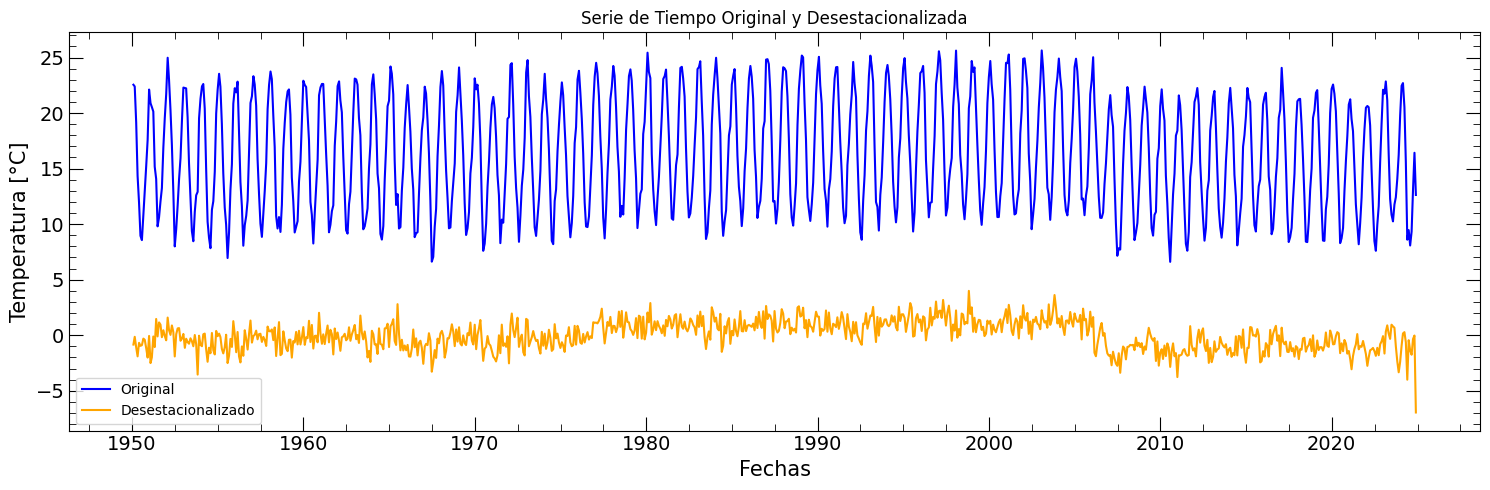

In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(15, 5))


path = os.getcwd()
file_path = os.path.join(path, "time_series_data", "330020_XXXX_Temperatura_.csv")

df = pd.read_csv(file_path, parse_dates=True, index_col=1, delimiter=";")
df.index = pd.to_datetime(df.index, format="%d-%m-%Y %H:%M:%S")

df_daily = df.resample("D").mean()  # Resampling diario
df_monthly = df_daily.resample("M").mean()  # Resampling mensual

# Obtener el ciclo anual promedio por mes
monthly_average = df_monthly.groupby(df_monthly.index.month).mean()

# Crear una nueva columna para los valores desestacionalizados la cual es una copia de los valores de temperatua
df_monthly['Deseasonalized'] = df_monthly["Ts_Valor"].copy()

### remover ciclo anual promedio (promedio mensual):
for month in range(1, 13):
    
    month_average = monthly_average.loc[month, "Ts_Valor"]
    ### Restar promedio mensual a los datos
    df_monthly.loc[df_monthly.index.month == month, 'Deseasonalized'] -= month_average

axs.plot(df_monthly.index, df_monthly["Ts_Valor"], label='Original', color='blue')
axs.plot(df_monthly.index, df_monthly['Deseasonalized'], label='Desestacionalizado', color='orange')
axs.set_title('Serie de Tiempo Original y Desestacionalizada')
axs.legend()

axs.set_ylabel("Temperatura [°C]", fontsize=15)
axs.set_xlabel("Fechas", fontsize=15)

axs.minorticks_on()
            
axs.tick_params(direction='in', right=True, top=True)
axs.yaxis.set_tick_params(labelsize=14)
axs.xaxis.set_tick_params(labelsize=14)

axs.tick_params(direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
axs.tick_params(direction='in', which='major', length=10, bottom=True, top=True, left=True, right=True)

plt.tight_layout()
plt.show()


        
        

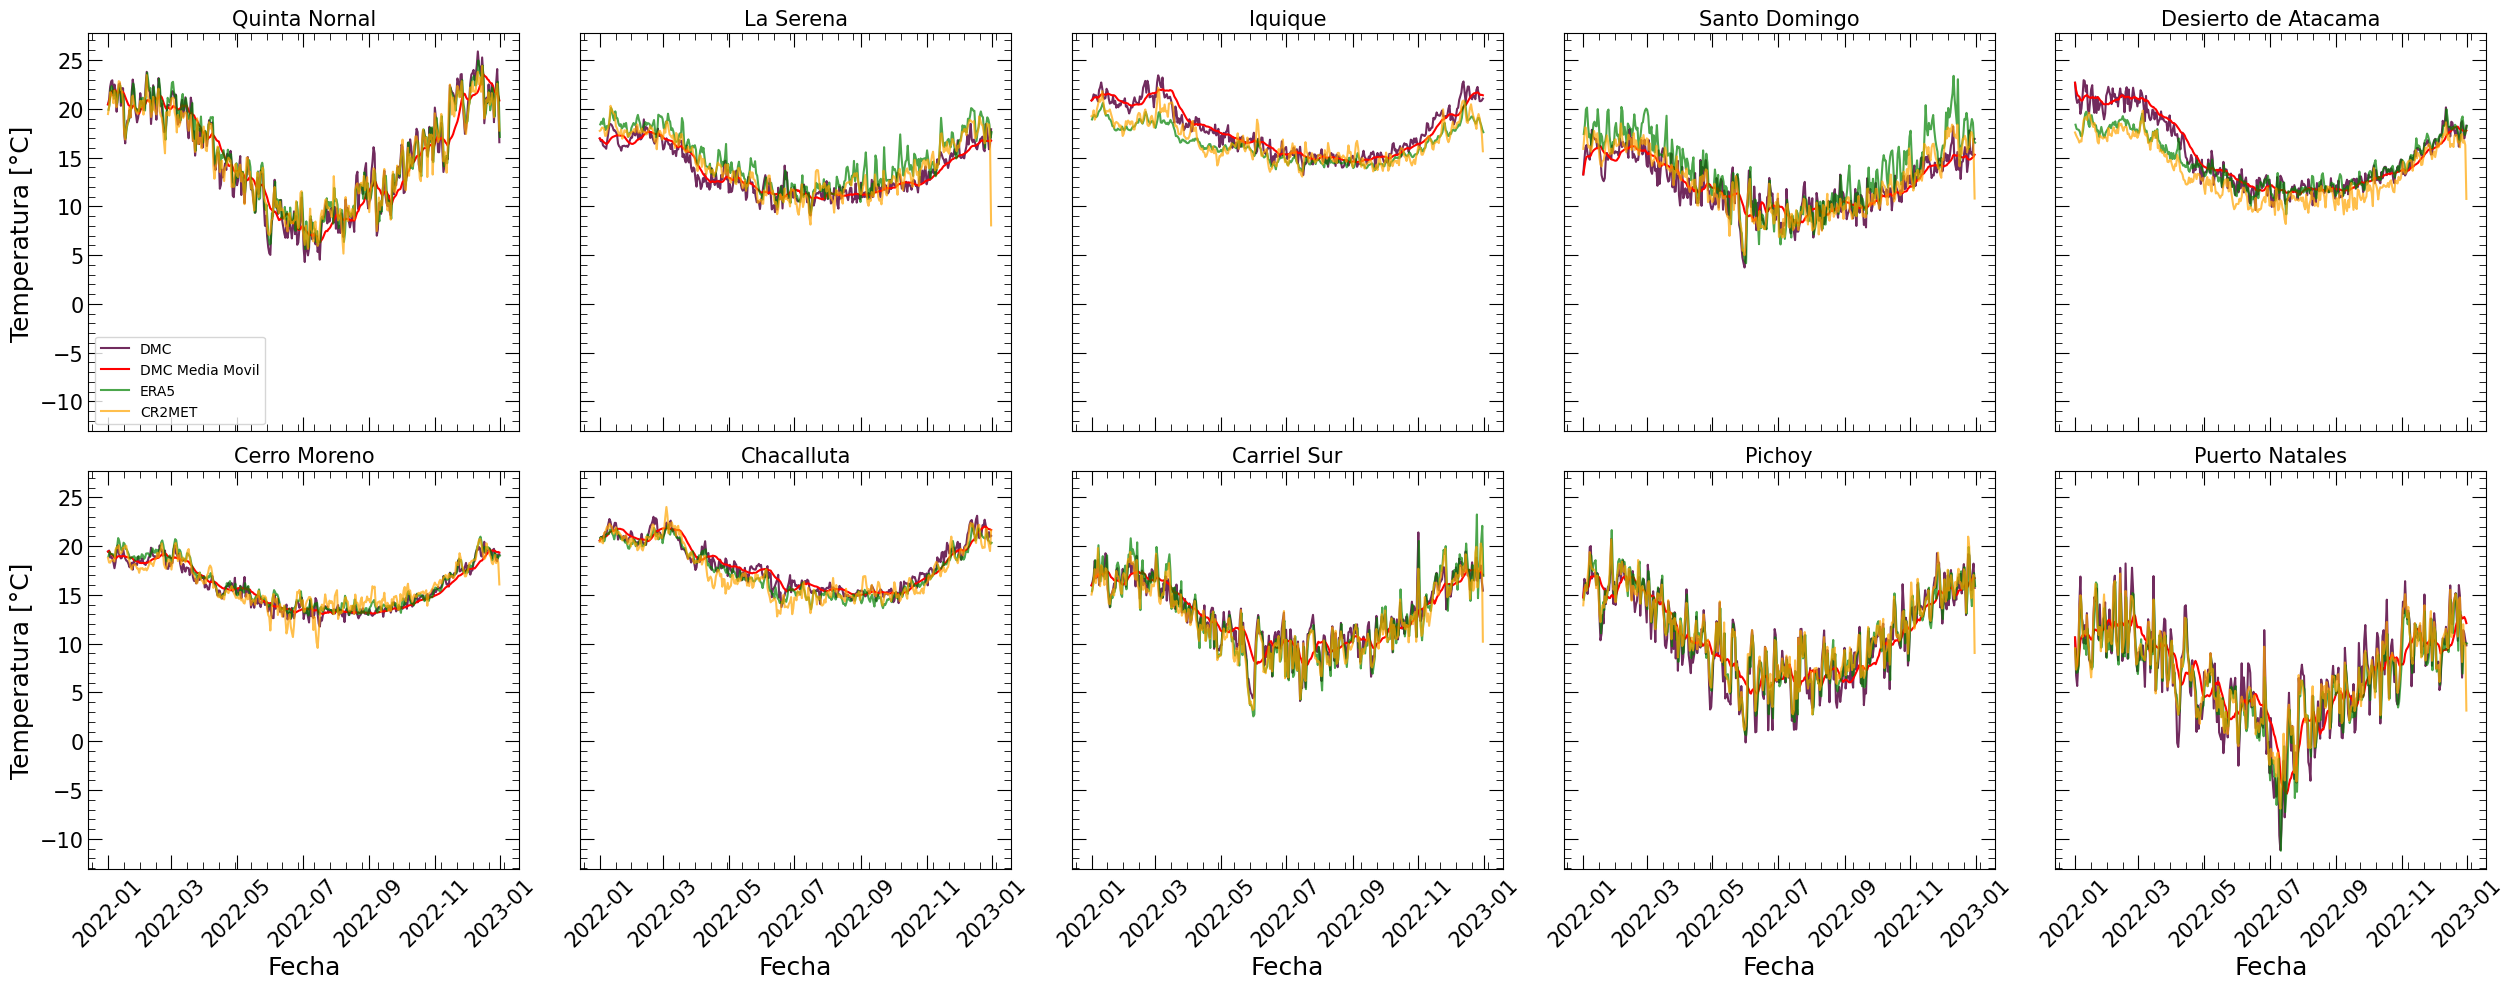

In [3]:
import pandas as pd
import os as os
import matplotlib.pyplot as plt
import glob 
import seaborn as sns
import xarray as xr

fig, axs = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey=True)

### Con este comando los axs pasan de tener dimensión 2x5 a una lista de 10
axs = axs.flatten()

path = os.getcwd()

path_files = os.path.join(path, "time_series_data", "dmc")
path_ncfiles = os.path.join(path, "gridded_data")


csv_files = glob.glob(os.path.join(path_files, "*.csv"))

colors = sns.color_palette("rocket",10)

df_stations = pd.read_excel( os.path.join(path_files, "stations_data.xlsx") )

data_era5 = xr.open_dataset(os.path.join(path_ncfiles, "ERA5", "processed", "mean", "2m_temperature_daily_mean.nc"))

data_cr2met = xr.open_dataset(os.path.join(path_ncfiles, "CR2MET", "processed", "mean", "CR2MET_tmean_2022_daily_mean.nc"))


for i, filename in enumerate(csv_files):
        
        ### separar path en una lista donde "/" corresponde al separador
        station_code = str(filename).split("/")
       
        file_path = os.path.join(path_files, filename)
        
        df = pd.read_csv(file_path, parse_dates=True, index_col=1, delimiter=";")
        
        df.index = pd.to_datetime(df.index, format="%d-%m-%Y %H:%M:%S")
        
        df = df.resample("D").mean()
         
        df_day = df.resample("D").mean()
        df_rolling = df_day.rolling("15D").mean()
        
        ### Obtener metadatos de la estación
        df_station_filtered = df_stations[df_stations["code" ] == float(station_code[-1].split("_")[0]) ]
        ### Obtener serie de tiempo de ERA5 y CR2MET a partir de latitud y longitud obtenidas de metadata de la estacion (punto más cercano).
        
        data_era5_selected = data_era5.sel(latitude=float(df_station_filtered["lat"].values[0]), longitude=float(df_station_filtered["lon"].values[0]), method="nearest")
        data_cr2met_selected = data_cr2met.sel(lat=float(df_station_filtered["lat"].values[0]), lon=float(df_station_filtered["lon"].values[0]), method="nearest")

        axs[i].plot(df.index, df["Ts_Valor"], color=colors[2], alpha=0.95, linewidth=1.5, label='DMC')
        
        axs[i].plot(df_rolling.index, df_rolling["Ts_Valor"], color="red", alpha=1, linewidth=1.5, label='DMC Media Movil')

        axs[i].plot( data_era5_selected["time"], data_era5_selected["t2m"] -273.15, color="green", alpha=0.7, linewidth=1.5, label='ERA5')

        axs[i].plot( data_cr2met_selected["time"], data_cr2met_selected["tmean"], color="orange", alpha=0.7, linewidth=1.5, label='CR2MET')

        # Mapear codigo y nombre de la estación
        axs[i].set_title(df_stations[df_stations["code" ] == float(station_code[-1].split("_")[0]) ]["station_name"].values[0], fontsize=15)
        
        axs[i].minorticks_on()
            
        axs[i].tick_params(direction='in', right=True, top=True)
        axs[i].yaxis.set_tick_params(labelsize=15)
        axs[i].xaxis.set_tick_params(labelsize=15)

        axs[i].tick_params(direction='in', which='minor', length=5, bottom=True, top=True, left=True, right=True)
        axs[i].tick_params(direction='in', which='major', length=10, bottom=True, top=True, left=True, right=True)

        
        if i>4:
                axs[i].set_xlabel("Fecha", fontsize=18)
                axs[i].tick_params(axis='x', rotation=45) 

        
plt.tight_layout()
axs[0].set_ylabel("Temperatura [°C]", fontsize=18 )
axs[5].set_ylabel("Temperatura [°C]", fontsize=18  )

axs[0].legend()

plt.show()
